In [1]:
import pandas as pd

In [2]:
import multiprocessing as mp
from sklearn import preprocessing

In [3]:
#citation_df = pd.read_csv('http://s3.amazonaws.com/data.patentsview.org/20181127/download/uspatentcitation.tsv.zip', sep='\t')

In [4]:
df = pd.read_json('cs_cpc_training_500.json')

In [5]:
df.head()

,publication_number,grant_date,cpc
0,9022049,20150505,"[A45, A45B, A]"
1,9025696,20150505,"[H04L27/26, H04L, H04B7/06, H04B7/0413, H04B7/..."
10,9033154,20150519,"[A61B90/00, A, B, A61, B65D, B65, A61B, A61B50..."
100,9036956,20150519,"[G02B6/0081, G02B6/24, G02B6/10, G02B6/42, G02..."
1000,9034866,20150519,"[C07D513/00, C07D487/00, C, C07D, C07D519/00, ..."


In [6]:
#df_CPC_G = df[df['cpc'].str.contains("G", regex=False)]

In [7]:
df['pub_date'] = pd.to_datetime(df['grant_date'], format='%Y%m%d')

In [8]:
df = df.loc[df['pub_date'] > '2015-01-01']

In [9]:
df['GrantYearMonth'] = pd.to_datetime(df['pub_date']).dt.to_period('M')

In [10]:
def extract_section_to_sc(dataframe):
    sect = []
    for i in range(dataframe.shape[0]):
        st = dataframe.iloc[i,2]
        f = []
        for x in st:
            g = x[0:4]
            f.append(g)
        f = list(set(f))
        sect.append(f)
    return sect

In [11]:
df['short_cpc'] = extract_section_to_sc(df)

In [12]:
mlb = preprocessing.MultiLabelBinarizer()
cpc_ohe_df = pd.DataFrame(mlb.fit_transform(df['short_cpc']),columns=mlb.classes_, index=df.index)

In [13]:
df1 = pd.concat([df, cpc_ohe_df], axis = 1)

In [14]:
df1 = df1.drop(['cpc', 'pub_date', 'publication_number', 'grant_date', 'short_cpc'], axis=1)

In [15]:
df1.head()

,GrantYearMonth,A,A01,A01B,A01C,A01D,A01F,A01G,A01H,A01J,...,H04N,H04Q,H04R,H04S,H04W,H05,H05B,H05G,H05H,H05K
0,2015-05,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2015-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10,2015-05,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,2015-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000,2015-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
import math

In [17]:
#def test_idf(series):
#    idf = math.log10(len(series)/(1 + series.sum()))
#    return(idf)

In [18]:
#dfgroup = df1.groupby(['GrantYearMonth']).agg(test_idf)
dfgroup = df1.groupby(['GrantYearMonth']).agg('sum')

In [4]:
#df2 = pd.DataFrame(dfgroup.to_records(), index=dfgroup.index)
df2 = pd.read_csv('cpcs_by_month2015.csv')

In [5]:
test = ['G05D', 'G06K', 'G08G']
meat = ['A23L', 'A23J']

In [10]:
test_df = df2[test]

In [6]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

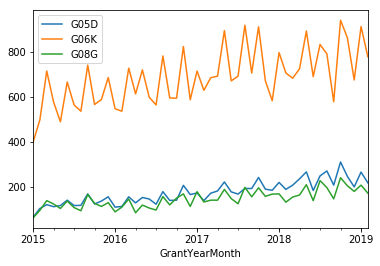

In [50]:
plt.figure()
test_df.plot()

In [24]:
# Create 10 equal bins
s = pd.cut(test_df['G05D'],10, retbins=True, labels=False)

In [7]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M


In [8]:
def sys_entropy(t_matrix):
    n = len(t_matrix)
    e = []
    for i in range(n):
        for j in range(n):
            ij = t_matrix[i][j]
            if ij == 0:
                e.append(0)
            else:
                e.append(ij * math.log2(ij))
    Entropy = (1/(n*math.log(1/n))) * sum(e)
    
    return Entropy

In [9]:
for t in test:
    s = pd.cut(test_df[t],10, retbins=True, labels=False)
    print(sys_entropy(transition_matrix(s[0])))

NameError: name 'test_df' is not defined

In [56]:
df2.to_csv('cpcs_by_month2015.csv')

In [57]:
bins = [5, 10, 15, 20, 25, 30, 40, 50]

for b in bins:
    s = pd.cut(test_df['G05D'],b, retbins=True, labels=False)
    print(sys_entropy(transition_matrix(s[0])))

0.746146395169353
0.6338935463899792
0.4515824442628343
0.32122126510417787
0.2711542668678346
0.18372687120490555
0.13166647948277851
0.08864901857082452


In [58]:
bins = [5, 10, 15, 20, 25, 30, 40, 50]

for b in bins:
    s = pd.cut(test_df['G06K'],b, retbins=True, labels=False)
    print(sys_entropy(transition_matrix(s[0])))

0.8985825444292843
0.5147430307206327
0.4445620287249977
0.2786782343542464
0.2473161825374701
0.1761369986063591
0.12187783862524595
0.09463019506093708


In [8]:
import numpy as np

In [9]:
edge = np.histogram_bin_edges(test_df['G05D'], bins='auto')
edge

array([ 64.        ,  99.14285714, 134.28571429, 169.42857143,
       204.57142857, 239.71428571, 274.85714286, 310.        ])

In [18]:
for t in test:
    edge = np.histogram_bin_edges(test_df[t], bins='auto')
    s = pd.cut(test_df[t],edge, retbins=True, labels=False, include_lowest=True)
    print(sys_entropy(transition_matrix(s[0])))

0.6522380282390727
0.7046977319220284
0.7250632769285205


In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [180]:
X = np.arange(len(df2))
Y = test_df.sum(axis=1)/df2.iloc[:,1:].sum(axis=1)

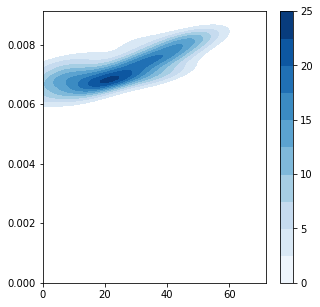

In [181]:
fig, ax = plt.subplots(figsize=(5,5))
sns.kdeplot(X, Y, cmap="Blues", shade=True, shade_lowest=False, ax=ax, cbar = True)
ax.set_xlim(0, None)
ax.set_ylim(0, None)
plt.show()